<font size="+3"><strong>Predicting Apartment Prices in Mexico City</strong></font>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from glob import glob
from category_encoders import OneHotEncoder
from ipywidgets import interact, Dropdown, FloatSlider, IntSlider
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [4]:
dft = pd.read_csv("data/mexico-city-real-estate-1.csv")
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4628 entries, 0 to 4627
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   4628 non-null   object 
 1   property_type               4628 non-null   object 
 2   place_with_parent_names     4628 non-null   object 
 3   lat-lon                     4144 non-null   object 
 4   price                       4538 non-null   float64
 5   currency                    4538 non-null   object 
 6   price_aprox_local_currency  4538 non-null   float64
 7   price_aprox_usd             4538 non-null   float64
 8   surface_total_in_m2         1668 non-null   float64
 9   surface_covered_in_m2       4436 non-null   float64
 10  price_usd_per_m2            1150 non-null   float64
 11  price_per_m2                4249 non-null   float64
 12  floor                       291 non-null    float64
 13  rooms                       136 n

### Write a wrangle function that takes the name of a CSV file as input and returns a DataFrame. The function should do the following steps:

1. Subset the data in the CSV file and return only apartments in Mexico City ("Distrito Federal") that cost less than $100,000.
2. Remove outliers by trimming the bottom and top 10% of properties in terms of "surface_covered_in_m2".
3. Create separate "lat" and "lon" columns
4. Mexico City is divided into 16 boroughs. Create a "borough" feature from the "place_with_parent_names" column.
5. Drop columns that are more than 50% null values.
6. Drop columns containing low- or high-cardinality categorical values.
7. Drop any columns that would constitute leakage for the target "price_aprox_usd".
8. Drop any columns that would create issues of multicollinearity.

In [5]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
     
    # Drop columns with misssing values greater than 50%
    for column in df.columns:
        if df[column].isnull().sum() > len(df)/2:
            df.drop(columns = [column], inplace = True)
            
    # Drop rows with empty values
    #df.dropna(inplace = True)
            
    # Subset data: Apartment in "Distrito Federal" that is less than $100,000.
    mask_loc = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_type = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 100000
    df = df[mask_loc & mask_type & mask_price]
            
    # Subset removing outliers in surface_covered_in_m2
    lower, higher = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(lower, higher)
    df = df[mask_area]
    
    # Seperate and drop "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand = True).astype(float)
    df.drop(columns = ["lat-lon"], inplace = True)
    
    # Create "borough" feature from "place_with_parent_names"
    df["borough"] = df["place_with_parent_names"].str.split("|", expand = True)[1]
    df.drop(columns = ["place_with_parent_names"], inplace = True)
    
    # Drop categorical values with high or low cardinarlity 
    df.drop(columns = ["operation", "property_type", "currency", "properati_url"], inplace = True)
    
    # Drop leaky columns
    df.drop(columns = ["price", "price_aprox_local_currency", "price_per_m2"], inplace = True)
    
    # Non of the columns are co-linear
    
    return df

In [6]:
# Use this cell to test your wrangle function and explore the data
df = wrangle("data/mexico-city-real-estate-1.csv")
df

,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán
...,...,...,...,...,...
4596,73761.07,85.0,19.375733,-99.139518,Benito Juárez
4597,32165.09,60.0,19.325608,-99.061120,Iztapalapa
4598,81664.04,90.0,19.441043,-99.175585,Miguel Hidalgo
4599,32770.99,50.0,19.442796,-99.154915,Cuauhtémoc


### Use glob to create the list files. It should contain the filenames of all the Mexico City real estate CSVs in the ./data directory, except for mexico-city-test-features.csv.

In [7]:
files = glob("data/mexico-city-real-estate-*.csv")
files

['../input/real-estate-datasets/mexico-city-real-estate-5.csv',
 '../input/real-estate-datasets/mexico-city-real-estate-4.csv',
 '../input/real-estate-datasets/mexico-city-real-estate-1.csv',
 '../input/real-estate-datasets/mexico-city-real-estate-2.csv',
 '../input/real-estate-datasets/mexico-city-real-estate-3.csv']

### Combine your wrangle function, a list comprehension, and pd.concat to create a DataFrame df. It should contain all the properties from the five CSVs in files.

In [8]:
frames = [wrangle(file) for file in files]
df = pd.concat(frames)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5473 entries, 1 to 4622
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 256.5+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
1,82737.39,75.0,19.362690,-99.150565,Benito Juárez
3,72197.60,62.0,19.291345,-99.124312,Tlalpan
4,44277.72,85.0,19.354987,-99.061709,Iztapalapa
13,60589.45,52.0,19.469681,-99.086136,Gustavo A. Madero
18,47429.08,53.0,19.443592,-99.121407,Venustiano Carranza


###  Create a histogram showing the distribution of apartment prices ("price_aprox_usd") in df. Be sure to label the x-axis "Area [sq meters]", the y-axis "Count", and give it the title "Distribution of Apartment Prices"

What does the distribution of price look like? Is the data normal, a little skewed, or very skewed?

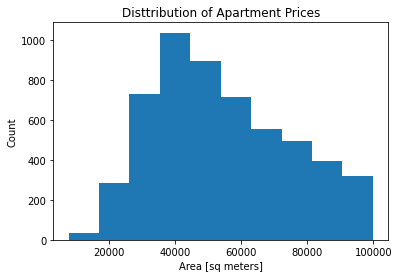

In [9]:
plt.hist(df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Count")
plt.title("Disttribution of Apartment Prices");

### Check for cardinality

In [10]:
df.select_dtypes("object")

,borough
1,Benito Juárez
3,Tlalpan
4,Iztapalapa
13,Gustavo A. Madero
18,Venustiano Carranza
...,...
4598,Benito Juárez
4601,Cuauhtémoc
4612,Miguel Hidalgo
4615,Coyoacán


In [11]:
df.select_dtypes("object").nunique()

borough    15
dtype: int64

### Checking for leakage

In [12]:
sorted(df.columns)

['borough', 'lat', 'lon', 'price_aprox_usd', 'surface_covered_in_m2']

### Checking for co-linearity in our features

In [13]:
corr = df.select_dtypes("number").drop(columns = ["price_aprox_usd"]).corr()
corr

,surface_covered_in_m2,lat,lon
surface_covered_in_m2,1.000000,-0.033695,-0.002994
lat,-0.033695,1.000000,-0.852599
lon,-0.002994,-0.852599,1.000000


<AxesSubplot:>

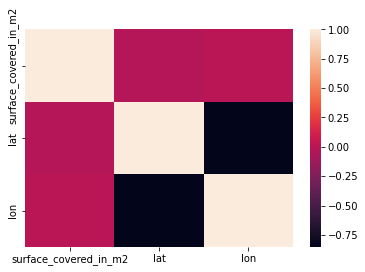

In [14]:
sns.heatmap(corr)

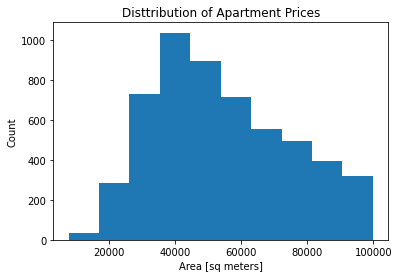

In [15]:
# Plot distribution of price
plt.hist(df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Count")
plt.title("Disttribution of Apartment Prices");

- Create a scatter plot that shows apartment price (`"price_aprox_usd"`) as a function of apartment size (`"surface_covered_in_m2"`).
- Be sure to label your axes `"Price [USD]"` and `"Area [sq meters]"`, respectively. Your plot should have the title `"Mexico City: Price vs. Area"`.

- Do you see a relationship between price and area in the data? How is this similar to or different from the Buenos Aires dataset?

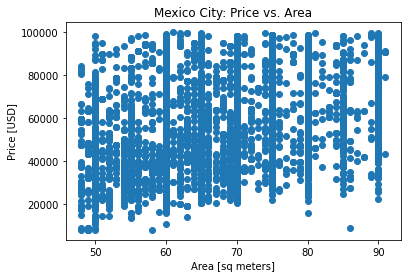

In [16]:
# Plot price vs area
plt.scatter(x = df["surface_covered_in_m2"], y = df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Mexico City: Price vs. Area");

- Create a Mapbox scatter plot that shows the location of the apartments in your dataset and represent their price using color. 

- What areas of the city seem to have higher real estate prices?

In [17]:
# Plot Mapbox location and price
fig = px.scatter_mapbox(
    df,
    lat = "lat",
    lon = "lon",
    #center = {"lat": 19.6345, "lon": -99.5528},
    color = "price_aprox_usd",
    width = 900,
    height = 600,
    hover_data = ["borough", "surface_covered_in_m2", "price_aprox_usd"]
);

fig.update_layout(mapbox_style="open-street-map")
fig.show()

## Split

- Create your feature matrix `X_train` and target vector `y_train`. Your target is `"price_aprox_usd"`.
- Your features should be all the columns that remain in the DataFrame you cleaned above.

In [18]:
# Split data into feature matrix `X_train` and target vector `y_train`.
target = "price_aprox_usd"
feature = []
for column in df.columns:
    if column != target:
        feature.append(column)
X_train = df[feature]
y_train = df[target]

In [19]:
feature

['surface_covered_in_m2', 'lat', 'lon', 'borough']

## Build Model

## **Baseline:** Calculate the baseline mean absolute error for your model.

In [20]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54246.5314982642
Baseline MAE: 17239.939475888295


### Iterate

Create a pipeline named `model` that contains all the transformers necessary for this dataset and one of the predictors you've used during this project. Then fit your model to the training data

In [21]:
# Build Model
model = make_pipeline(
        OneHotEncoder(use_cat_names=True),
        SimpleImputer(),
        LinearRegression()
)
# Fit model
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

### Evaluate

Read the CSV file `mexico-city-test-features.csv` into the DataFrame `X_test`.

In [22]:
X_test = pd.read_csv("data/mexico-city-test-features.csv")
print(X_test.info())
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   float64
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(3), object(1)
memory usage: 32.7+ KB
None


,surface_covered_in_m2,lat,lon,borough
0,60.0,19.493185,-99.205755,Azcapotzalco
1,55.0,19.307247,-99.166700,Coyoacán
2,50.0,19.363469,-99.010141,Iztapalapa
3,60.0,19.474655,-99.189277,Azcapotzalco
4,74.0,19.394628,-99.143842,Benito Juárez


## Predict

Use your model to generate a Series of predictions for X_test. When you submit your predictions to the grader, it will calculate the mean absolute error for your model.

In [23]:
y_test_pred = pd.Series(model.predict(X_train))
y_test_pred.head()

0    69045.956294
1    61738.672878
2    44553.073032
3    41787.858338
4    43182.988731
dtype: float64

Create a Series named `feat_imp`. The index should contain the names of all the features your model considers when making predictions; the values should be the coefficient values associated with each feature. The Series should be sorted ascending by absolute value.

In [24]:
coefficients = model.named_steps["linearregression"].coef_
features = model.named_steps["onehotencoder"].get_feature_names()
feat_imp = pd.Series(coefficients, index = features)
feat_imp

surface_covered_in_m2               291.088836
lat                                 482.269297
lon                               -2486.167319
borough_Benito Juárez             13778.254729
borough_Tlalpan                   10354.803035
borough_Iztapalapa               -13400.891089
borough_Gustavo A. Madero         -6676.217197
borough_Venustiano Carranza       -5647.283325
borough_Iztacalco                   385.010954
borough_Coyoacán                   3730.604024
borough_Cuauhtémoc                 -370.237325
borough_Miguel Hidalgo             1962.984604
borough_Azcapotzalco               2446.320298
borough_Tláhuac                  -14282.520368
borough_Álvaro Obregón             3265.142292
borough_La Magdalena Contreras    -6226.163491
borough_Xochimilco                  931.276706
borough_Cuajimalpa de Morelos      9748.916152
dtype: float64

 Create a horizontal bar chart that shows the 10 most influential coefficients for your model. Be sure to label your x- and y-axis "Importance [USD]" and "Feature", respectively, and give your chart the title "Feature Importances for Apartment Price".

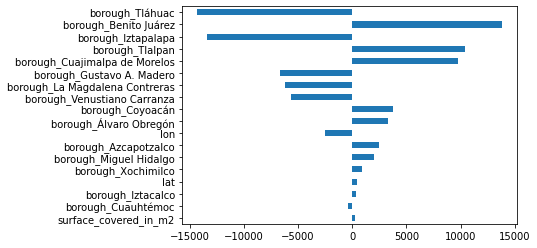

In [25]:
# Create horizontal bar chart
feat_imp.sort_values(key= abs).plot(kind= "barh")
# Don't delete the code below 👇
plt.savefig("./top10_coeff.png", dpi=150)

### Communicate Result

For this lesson, I relied on equations and visualizations for communication about my model. In many data science projects, however, communication means giving stakeholders tools they can use to **deploy** a model — in other words, use it in action. So let's look at two ways you might deploy this model. 

One thing you might be asked to do it wrap your model in a function so that a programmer can provide inputs and then receive a prediction as output. 

Create a function predict_price that takes four arguments (area, lat, lon, and neighborhood) and returns your model's prediction for an apartment price.

In [29]:
def predict_price(area, lat, lon, borough):
    data = {
        "surface_covered_in_m2": area,
        "lat": lat,
        "lon": lon,
        "borough": borough
    }
    df = pd.DataFrame(data, index = [0])
    
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [ ]:
## Example
predict_price(100, 18, -100, "Azcapotzalco")

Another type of deployment is creating and interactive dashboard, where a user can supply values and receive a prediction. Let's create one using [Jupyter Widgets](https://ipywidgets.readthedocs.io/en/latest/index.html).

Add your make_prediction to the interact widget below, run the cell, and then adjust the widget to see how predicted apartment price changes.

In [40]:
interact(
    predict_price,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    borough=Dropdown(options=sorted(X_train["borough"].unique())),
);

interactive(children=(IntSlider(value=66, description='area', max=91, min=48), FloatSlider(value=19.4531123034…

## Credict
World Quant University